In [1]:
import pandas as pd

jpet = pd.read_excel('no_abstract/no_abstract.xlsx',index_col=0)

In [2]:
jpet

,Sequence,Item,LineItem,Order,Product,CartItem,Category,Cart,Account,SequenceMapper,...,bannerdata(table),sequence(table),orderstatus(table),orders(table),inventory(table),product(table),item(table),category(table),suppllier(table),lineitem(table)
/class/@id,,,,,,,,,,,,,,,,,,,,,
Sequence,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Item,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LineItem,0,2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Order,0,0,2,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
Product,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CartItem,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Category,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cart,0,1,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Account,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


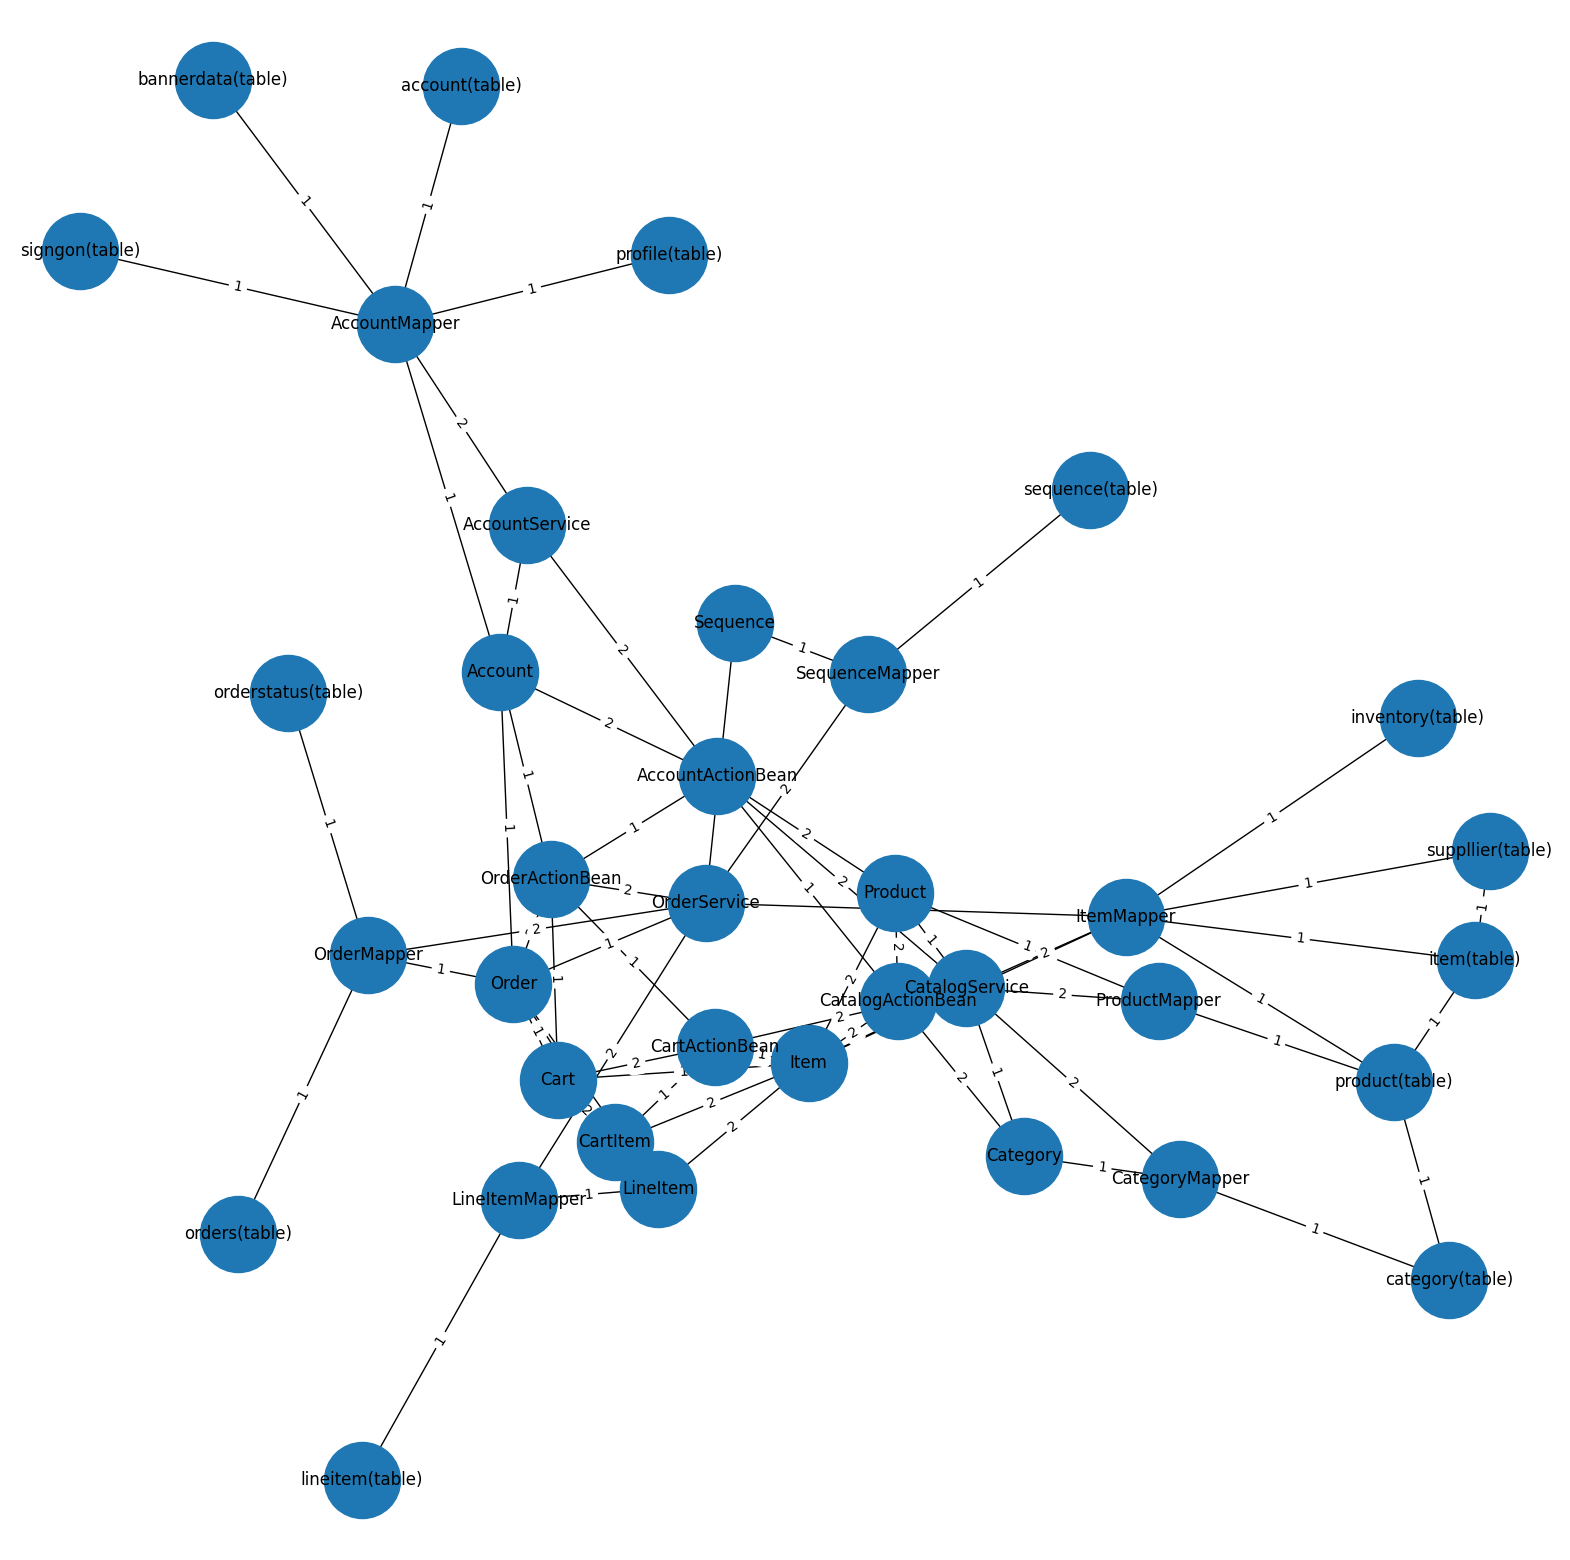

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
fig = plt.figure(1)
G=nx.from_pandas_adjacency(jpet, create_using = nx.path_graph(4))
df = pd.DataFrame(index=G.nodes(), columns=G.nodes())
for row, data in nx.shortest_path_length(G):
    for col, dist in data.items():
        df.loc[row,col] = dist

df = df.fillna(df.max().max())

edge_labels=dict([((u,v,),d['weight'])
                 for u,v,d in G.edges(data=True)])
edge_colors = ['black']

pos = nx.spring_layout(G,k=0.15,iterations=20)

nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)

nx.draw(G, pos, node_size=3000, edge_color=edge_colors, with_labels=True, arrows=True)

fig.set_size_inches(20, 20)
plt.savefig("jpet_networkx_table")
plt.show()

Computing transition probabilities:   0%|          | 0/36 [00:00<?, ?it/s]

00, ['CatalogActionBean', 'CatalogService', 'CategoryMapper', 'category(table)', 'product(table)', 'item(table)', 'suppllier(table)', 'ItemMapper', 'inventory(table)', 'ItemMapper']
01, ['CartActionBean', 'Item', 'CatalogActionBean', 'Category', 'CategoryMapper', 'category(table)', 'product(table)', 'item(table)', 'suppllier(table)', 'item(table)']
02, ['CategoryMapper', 'CatalogService', 'ProductMapper', 'product(table)', 'category(table)', 'CategoryMapper', 'CatalogService', 'AccountActionBean', 'OrderActionBean', 'OrderService']
03, ['orderstatus(table)', 'OrderMapper', 'OrderService', 'OrderActionBean', 'Cart', 'CartItem', 'LineItem', 'LineItemMapper', 'OrderService', 'ItemMapper']


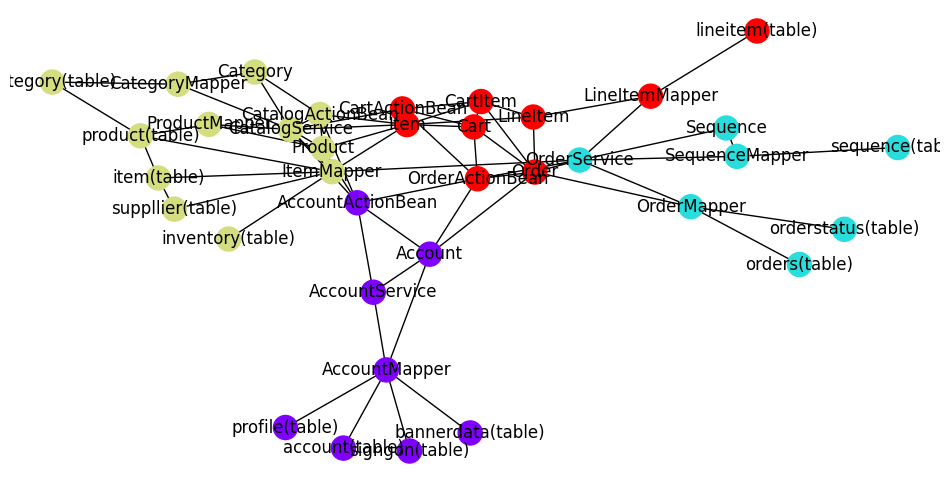

In [4]:
from node2vec import Node2Vec

import matplotlib.pyplot as plt 
plt.style.use('default')

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering



G=nx.from_pandas_adjacency(jpet, create_using = nx.karate_club_graph())
G = nx.relabel_nodes(G, { n:str(n) for n in G.nodes()})



node2vec = Node2Vec(graph=G, # target graph
                    dimensions=50, # embedding dimension
                    walk_length=10, # number of nodes in each walks 
                    p = 1, # return hyper parameter
                    q = 0.0001, # inout parameter
                    num_walks=2000, 
                    workers=4,
                   )

for i, each_walk in enumerate(node2vec.walks):
    print(f"{i:0>2d}, {each_walk}")
    if i>2:
        break

model1 = node2vec.fit(window=2)
# kmeans clustering
K = 4
kmeans = KMeans(n_clusters=K, random_state=0).fit(model1.wv.vectors)

#hier
#ag = AgglomerativeClustering(n_clusters=4)
#aoc = ag.fit(model1.wv.vectors)

#EM
#gmm = GaussianMixture(n_components=4, random_state=0).fit(model1.wv.vectors)
#gmm_labels = gmm.predict(model1.wv.vectors)

for n, label in zip(model1.wv.index2entity, kmeans.labels_):
    G.nodes[n]['label'] = label

plt.figure(figsize=(12, 6))
nx.draw_networkx(G, pos=nx.layout.spring_layout(G), 
                 node_color=[n[1]['label'] for n in G.nodes(data=True)], 
                 cmap=plt.cm.rainbow
                )
plt.axis('off')
plt.savefig('no_abstract_table_kmeans.png')

plt.show()




In [5]:
import numpy as np

In [6]:
result_data = np.array([n for n in G.nodes(data=True)])
df_result = pd.DataFrame(result_data)
df_result.to_csv('kmeans.csv', index=False)